In [6]:
#write scores into test sets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from minicons import scorer
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir('/home/qy2672/learning-alternations')

def safe_score_sequence(text, lm, tokenizer):
    try:
        device = next(lm.model.parameters()).device
        
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=256,
            padding=True
        ).to(device)  

        return lm.sequence_score(inputs)[0]
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return float('nan')
    
models = ['ditransitives_removed', 'datives_removed']
dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

for model_name in models:
    model_path = 'qing-yao/'+model_name+'_seed-42_1e-3'

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float32,
        device_map="auto"
    )

    lm = scorer.IncrementalLMScorer(
        model=model,
        device="auto",
        tokenizer=tokenizer
    )
    dos['do' + model_name] = dos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos['po' + model_name] = dos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos[model_name + '_ratio'] = dos['do'+model_name] - dos['po'+model_name]
    dos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    dos.to_csv('experiments/do_datives.csv', index = False)
    pos['do' + model_name] = pos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos['po' + model_name] = pos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos[model_name + '_ratio'] = pos['do'+model_name] - pos['po'+model_name]
    pos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    pos.to_csv('experiments/po_datives.csv', index = False)

In [1]:
# random model

from transformers import OPTConfig, OPTForCausalLM
import torch

def create_random_opt_model():
    # Load the configuration from the original model
    config = OPTConfig.from_pretrained('facebook/opt-125m')
    
    # Create a new model with random weights using the same architecture
    random_model = OPTForCausalLM(config)
    
    # Optionally, ensure truly random initialization
    def reinitialize_weights(model):
        for module in model.modules():
            if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if isinstance(module, torch.nn.Linear) and module.bias is not None:
                    module.bias.data.zero_()
    
    reinitialize_weights(random_model)
    return random_model

model = create_random_opt_model()

#write scores into test sets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from minicons import scorer
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir('/home/qy2672/learning-alternations')

def safe_score_sequence(text, lm, tokenizer):
    try:
        device = next(lm.model.parameters()).device
        
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=256,
            padding=True
        ).to(device)  

        return lm.sequence_score(inputs)[0]
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return float('nan')
    
dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')

model_name = 'random'

lm = scorer.IncrementalLMScorer(
    model=model,
    device="auto",
    tokenizer=tokenizer
)
dos['do' + model_name] = dos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
dos['po' + model_name] = dos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
dos[model_name + '_ratio'] = dos['do'+model_name] - dos['po'+model_name]
dos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
dos.to_csv('experiments/do_datives.csv', index = False)
pos['do' + model_name] = pos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
pos['po' + model_name] = pos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
pos[model_name + '_ratio'] = pos['do'+model_name] - pos['po'+model_name]
pos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
pos.to_csv('experiments/po_datives.csv', index = False)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

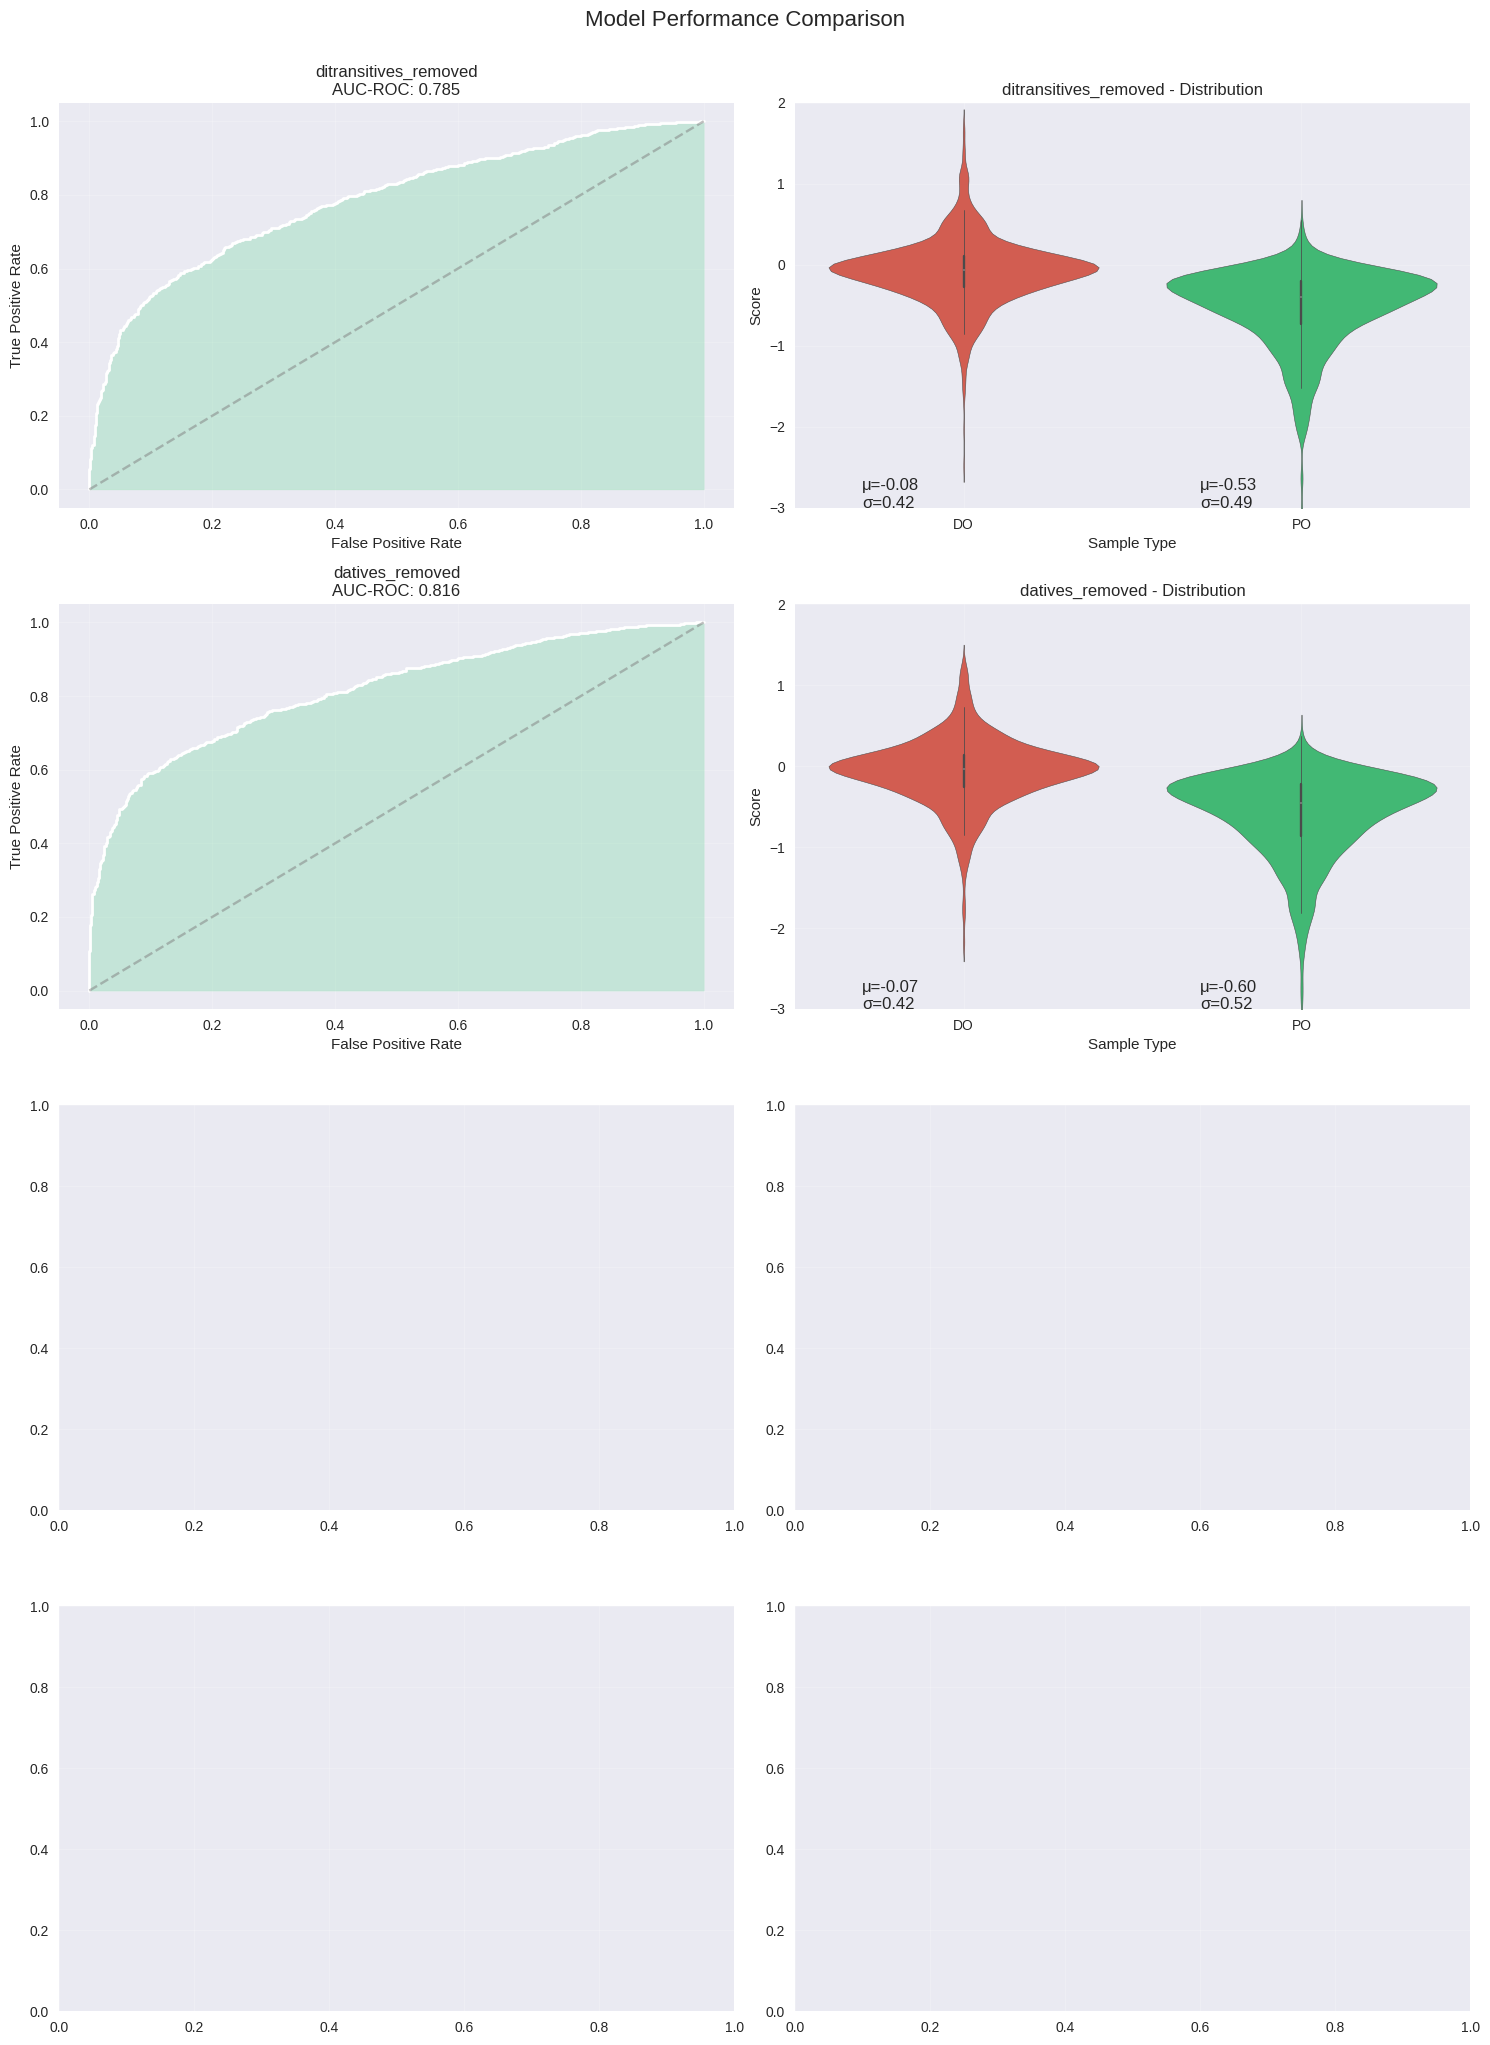

In [4]:
#model prediction on datives, compare distributions
import pandas as pd
import os 

os.chdir('/home/qy2672/learning-alternations')
pos = pd.read_csv('experiments/po_datives.csv')
dos = pd.read_csv('experiments/do_datives.csv')

models = ['ditransitives_removed', 'datives_removed']

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score


plt.style.use('seaborn-v0_8-dark')
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

po_color = '#2ecc71'  # green
do_color = '#e74c3c'  # red
po_color_dark = '#27ae60'  # darker green for swarm
do_color_dark = '#c0392b'  # darker red for swarm

def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_se

def distribution_overlap(x1, x2, bins=100):
    min_val = min(np.min(x1), np.min(x2))
    max_val = max(np.max(x1), np.max(x2))
    hist1, bins = np.histogram(x1, bins=bins, range=(min_val, max_val), density=True)
    hist2, _ = np.histogram(x2, bins=bins, range=(min_val, max_val), density=True)
    return np.sum(np.minimum(hist1, hist2)) * (bins[1] - bins[0])

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx, 0]
    # ax_combined = axes[idx, 1]
    ax_violin = axes[idx, 1]  
    
    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    
    # Calculate statistics
    cd = cohens_d(do_scores, po_scores)
    true_labels = [1] * len(do_scores) + [0] * len(po_scores)
    scores = np.concatenate([do_scores, po_scores])
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)
    overlap = distribution_overlap(do_scores, po_scores)
    
    # 1. ROC Curve 
    fpr, tpr, _ = roc_curve(true_labels, scores)
    ax_scatter.plot(fpr, tpr, color='white', linewidth=2)
    ax_scatter.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    ax_scatter.fill_between(fpr, tpr, alpha=0.2, color=po_color)
    ax_scatter.set_xlabel('False Positive Rate')
    ax_scatter.set_ylabel('True Positive Rate')
    ax_scatter.set_title(f'{model_name}\nAUC-ROC: {auc_score:.3f}')
    
    # 2. violin plot
    data = {
        'Score': np.concatenate([do_scores, po_scores]),
        'Sample Type': ['DO'] * len(do_scores) + ['PO'] * len(po_scores)
    }
    # Violin plot with box inside
    sns.violinplot(data=data, x='Sample Type', y='Score', 
                  inner='box', palette={'DO': do_color, 'PO': po_color}, hue = 'Sample Type',
                  ax=ax_violin)
    ax_violin.set_ylim(-3,2)

    # Add mean and std annotations to violin plot
    for i, (label, color) in enumerate([('DO', do_color), ('PO', po_color)]):
        scores = do_scores if label == 'DO' else po_scores
        ax_violin.text(i - 0.3, ax_violin.get_ylim()[0], 
              f'μ={np.mean(scores):.2f}\nσ={np.std(scores):.2f}',
              fontsize=12)
    
    ax_violin.set_title(f'{model_name} - Distribution')

# Adjust layout and styling
plt.tight_layout()
for ax in axes.flat:
    ax.grid(True, alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Model Performance Comparison', y=1.02, fontsize=16)

plt.show()

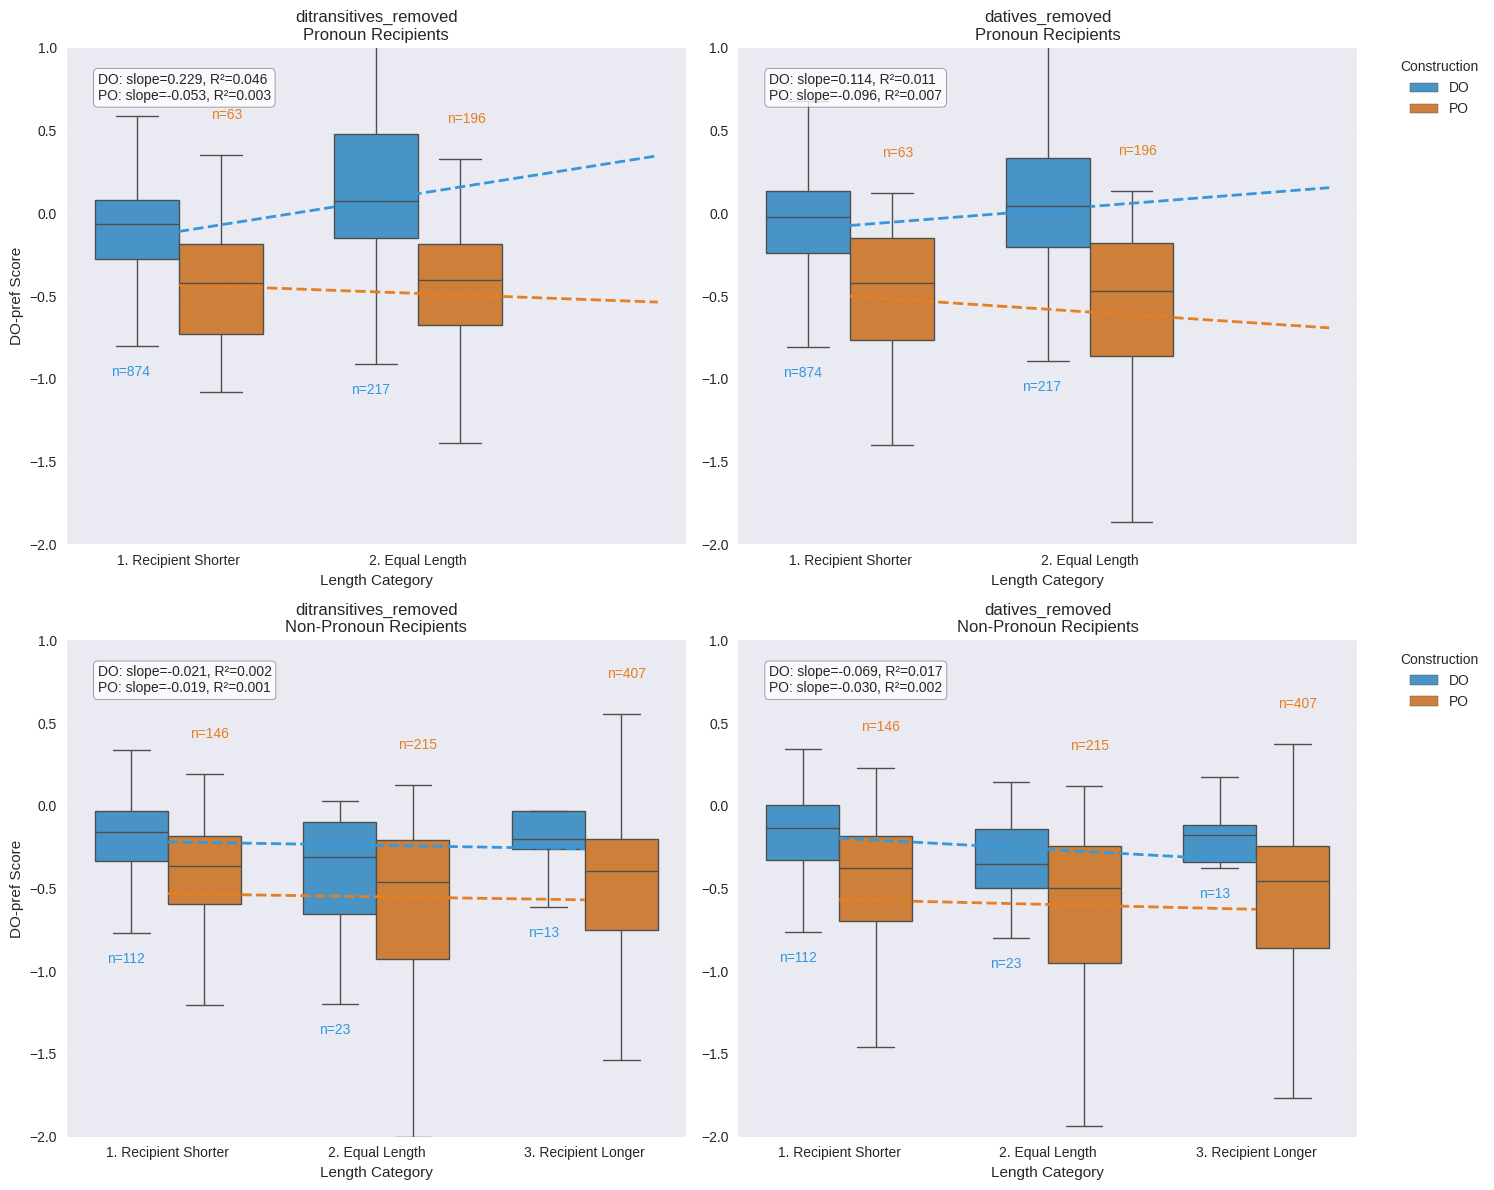


Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length
Construction                                     
DO                       0.206893       -0.621138
PO                       -1.51269        1.306647

Contingency Table (Counts):
len_category  1. Recipient Shorter  2. Equal Length
Construction                                       
DO                             874              217
PO                              63              196

Chi-square statistic: 304.149
p-value: 4.110e-68

Non-Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length 3. Recipient Longer
Construction                                                         
DO                       1.425878       -0.741505           -2.384055
PO                      -0.567161        0.107616            0.208881



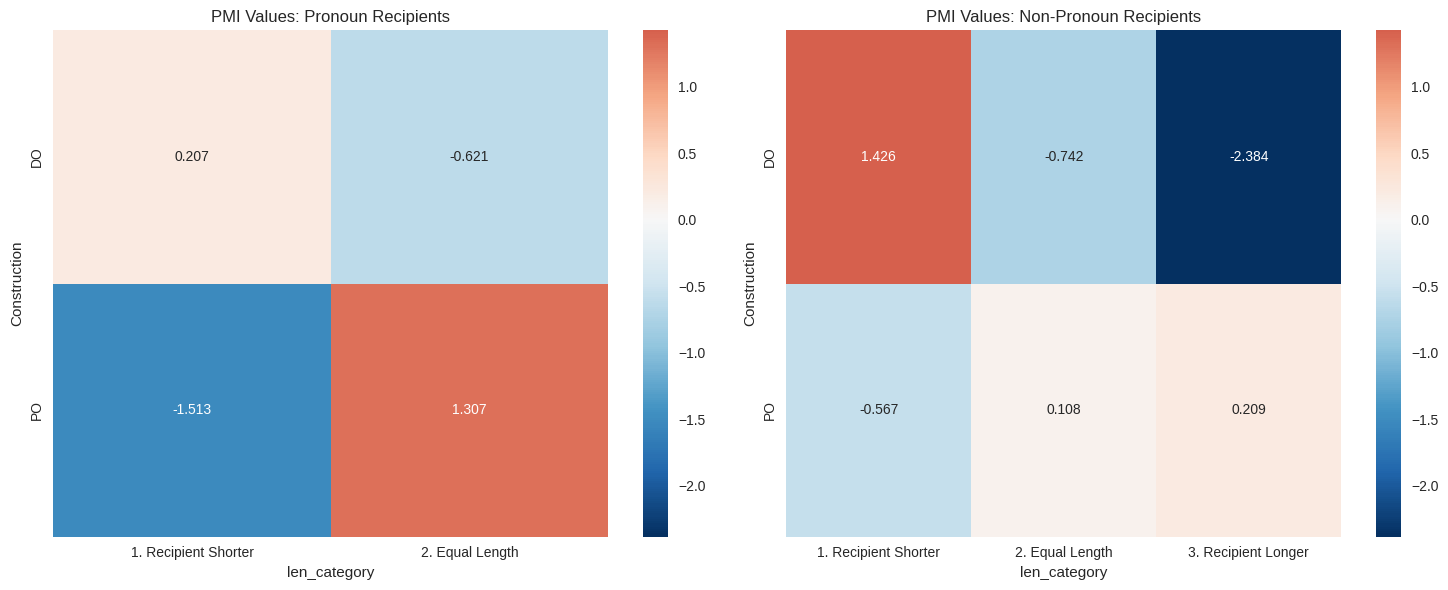

In [1]:
#cluster when sorted by length 
import pandas as pd
import os 

os.chdir('/home/qy2672/learning-alternations')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

dos_p = dos[dos['recipient_pos'] == 'PRON']
pos_p = pos[pos['recipient_pos'] == 'PRON']
dos_notp = dos[dos['recipient_pos'] != 'PRON']
pos_notp = pos[pos['recipient_pos'] != 'PRON']

def add_length_category(df):
    df = df.copy()
    df['rec_len'] = df['recipient'].str.split().str.len()
    df['theme_len'] = df['theme'].str.split().str.len()
    df['len_category'] = np.where(df['rec_len'] < df['theme_len'], '1. Recipient Shorter',
                                np.where(df['rec_len'] == df['theme_len'], '2. Equal Length',
                                        '3. Recipient Longer'))
    return df

# Process dataframes
dos_p = add_length_category(dos_p)
pos_p = add_length_category(pos_p)
dos_notp = add_length_category(dos_notp)
pos_notp = add_length_category(pos_notp)

def calculate_fit_stats(df, construction):
    # Convert length categories to numeric values for fitting
    category_map = {
        '1. Recipient Shorter': 0,
        '2. Equal Length': 1,
        '3. Recipient Longer': 2
    }
    x = df[df['Construction'] == construction]['Length Category'].map(category_map)
    y = df[df['Construction'] == construction]['Score']
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2, p_value

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

do_color = '#3498db'
po_color = '#e67e22'

plot_configs = [
    (0, 0, dos_p, pos_p, 'ditransitives_removed', 'Pronoun Recipients'),
    (0, 1, dos_p, pos_p, 'datives_removed', 'Pronoun Recipients'),
    (1, 0, dos_notp, pos_notp, 'ditransitives_removed', 'Non-Pronoun Recipients'),
    (1, 1, dos_notp, pos_notp, 'datives_removed', 'Non-Pronoun Recipients'),
]

for row, col, do_df, po_df, model_name, title in plot_configs:
    ax = axes[row, col]
    
    box_data = {
        'Score': np.concatenate([do_df[model_name + '_ratio'], 
                               po_df[model_name + '_ratio']]),
        'Construction': ['DO'] * len(do_df) + ['PO'] * len(po_df),
        'Length Category': np.concatenate([do_df['len_category'], 
                                        po_df['len_category']])
    }
    df_plot = pd.DataFrame(box_data)
    
    # Create box and strip plots
    sns.boxplot(data=df_plot, x='Length Category', y='Score', 
               hue='Construction', 
               palette={'DO': do_color, 'PO': po_color},
               width=0.7, showfliers=False, ax=ax)
    
    # sns.stripplot(data=df_plot, x='Length Category', y='Score', 
    #              hue='Construction', 
    #              palette={'DO': do_color, 'PO': po_color},
    #              dodge=True, size=4, alpha=0.3, ax=ax)
    for i, category in enumerate(df_plot['Length Category'].unique()):
        for j, construction in enumerate(['DO', 'PO']):
            # Get the subset of data for this category and construction
            subset = df_plot[(df_plot['Length Category'] == category) & 
                            (df_plot['Construction'] == construction)]
            count = len(subset)
            
            Q1 = subset['Score'].quantile(0.25)
            Q3 = subset['Score'].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            lower_bound = Q1 - 1.5 * IQR
            
            non_outlier_min = subset[subset['Score'] >= lower_bound]['Score'].min()
            non_outlier_max = subset[subset['Score'] >= lower_bound]['Score'].max()
            x_pos = i - 0.2 + (j * 0.4)
            y_pos = non_outlier_min - 0.2 if construction == 'DO' else non_outlier_max + 0.2
            
            # Add the count annotation
            ax.text(x_pos, y_pos, f'n={count}', 
                ha='center', va='bottom',
                color=do_color if construction == 'DO' else po_color)
    
    # Calculate and plot linear fits
    x_fit = np.array([0, 1, 2])  # Numeric values for categories
    
    # DO fit
    do_slope, do_intercept, do_r2, do_p = calculate_fit_stats(df_plot, 'DO')
    y_fit_do = do_slope * x_fit + do_intercept
    ax.plot(x_fit, y_fit_do, '--', color=do_color, linewidth=2)
    
    # PO fit
    po_slope, po_intercept, po_r2, po_p = calculate_fit_stats(df_plot, 'PO')
    y_fit_po = po_slope * x_fit + po_intercept
    ax.plot(x_fit, y_fit_po, '--', color=po_color, linewidth=2)
    
    # Add statistical annotations
    fit_stats_text = (f'DO: slope={do_slope:.3f}, R²={do_r2:.3f}\n'
                     f'PO: slope={po_slope:.3f}, R²={po_r2:.3f}')
    ax.text(0.05, 0.95, fit_stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_title(f'{model_name}\n{title}')
    ax.set_xlabel('Length Category')
    ax.set_ylabel('DO-pref Score' if col == 0 else '')
    ax.grid(True, alpha=0.2)
    ax.set_ylim(-2, 1)
    
    if col == 1:
        ax.legend(title='Construction', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend().remove()

plt.tight_layout()
plt.show()


from scipy.stats import chi2_contingency

def calculate_pmi(joint_prob, prob_x, prob_y):
    """Calculate PMI given probabilities"""
    return np.log2(joint_prob / (prob_x * prob_y))

def calculate_pmi_table(df_do, df_po):
    """Calculate PMI between construction type and length categories"""
    # Combine data
    do_data = df_do.copy()
    po_data = df_po.copy()
    do_data['Construction'] = 'DO'
    po_data['Construction'] = 'PO'
    combined = pd.concat([do_data, po_data])
    
    # Create contingency table
    contingency = pd.crosstab(combined['Construction'], 
                             combined['len_category'])
    
    # Calculate probabilities
    total = contingency.sum().sum()
    prob_construction = contingency.sum(axis=1) / total
    prob_length = contingency.sum(axis=0) / total
    
    # Calculate PMI for each cell
    pmi_values = pd.DataFrame(index=contingency.index, 
                            columns=contingency.columns)
    
    for const in contingency.index:
        for length in contingency.columns:
            joint_prob = contingency.loc[const, length] / total
            pmi_values.loc[const, length] = calculate_pmi(
                joint_prob,
                prob_construction[const],
                prob_length[length]
            )
    
    # Calculate chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    return pmi_values, chi2, p_value, contingency

# Calculate PMI for pronoun cases
pmi_pron, chi2_pron, p_pron, cont_pron = calculate_pmi_table(dos_p, pos_p)
# Calculate PMI for non-pronoun cases
pmi_nonpron, chi2_nonpron, p_nonpron, cont_nonpron = calculate_pmi_table(dos_notp, pos_notp)

# Create formatted output tables
def format_table(pmi_values, contingency, chi2, p_value, title):
    print(f"\n{title}")
    print("-" * 80)
    print("\nPMI Values:")
    print(pmi_values.round(3))
    print("\nContingency Table (Counts):")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.3f}")
    print(f"p-value: {p_value:.3e}")

# Display results
format_table(pmi_pron, cont_pron, chi2_pron, p_pron, "Pronoun Recipients")
format_table(pmi_nonpron, cont_nonpron, chi2_nonpron, p_nonpron, "Non-Pronoun Recipients")

# Visualize PMI values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot PMI heatmaps
vmin = min(pmi_pron.values.min(), pmi_nonpron.values.min())
vmax = max(pmi_pron.values.max(), pmi_nonpron.values.max())

sns.heatmap(pmi_pron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('PMI Values: Pronoun Recipients')

sns.heatmap(pmi_nonpron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('PMI Values: Non-Pronoun Recipients')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm

def prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, model_name):
    # Combine DO data
    dos_all = pd.concat([dos_p, dos_notp])
    dos_all['Construction'] = 'DO'
    
    # Combine PO data
    pos_all = pd.concat([pos_p, pos_notp])
    pos_all['Construction'] = 'PO'
    
    # Combine all data
    all_data = pd.concat([dos_all, pos_all])
    
    # Create dummy variables for length with 'Equal Length' as reference level
    all_data['length_shorter'] = np.where(all_data['len_category'] == '1. Recipient Shorter', 1, 0)
    all_data['length_longer'] = np.where(all_data['len_category'] == '3. Recipient Longer', 1, 0)
    
    # Create pronoun indicator
    all_data['is_pronoun'] = np.where(all_data['recipient_pos'] == 'PRON', 1, 0)
    
    # Get scores from specified model
    all_data['score'] = all_data[f'{model_name}_ratio']
    all_data['ditransitives_removed'] = 1 if model_name == 'ditransitives_removed' else 0
    
    return all_data

# Prepare and combine the data
data_default = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'datives_removed')
data_balanced = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'ditransitives_removed')
model_data = pd.concat([data_default, data_balanced])

# Create design matrix for fixed effects
X = sm.add_constant(model_data[[
    'is_pronoun',
    'length_shorter',
    'length_longer',
    'ditransitives_removed'
]])

# Fit the mixed effects model with verb as random effect
mixed_model = MixedLM(
    endog=model_data['score'],
    exog=X,
    groups=model_data['verb_lemma'],  # Use verb instead of item_id
    missing='drop'
)

results = mixed_model.fit()

# Create formatted table
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'  # Changed to match the paper's notation

# Create nice parameter names
param_names = {
    'const': '(Intercept)',
    'is_pronoun': 'recipient pronoun vs. non-pronoun',
    'length_shorter': 'recipient shorter vs. equal',
    'length_longer': 'recipient longer vs. equal',
    'ditransitives_removed': 'balanced vs. default model'
}

# Create the summary table
summary_table = pd.DataFrame({
    'regression term': [param_names.get(term, term) for term in results.params.index],
    'estimate': results.params.round(2),
    't statistic': results.tvalues.round(2),
    'p value': results.pvalues,
    'sig. level': [get_significance_stars(p) for p in results.pvalues]
})

# Format p-values in scientific notation
summary_table['p value'] = summary_table['p value'].apply(lambda x: f'{x:.2e}')

# Print the formatted table
print("Fixed Effects:")
print(summary_table.to_string(index=False))

# Print random effects variance components
print("\nRandom Effects:")
print(pd.DataFrame({
    'Group': ['verb', 'Residual'],
    'Variance': [results.cov_re.iloc[0,0], results.scale]
}).round(3))

# Print number of verbs (groups)
n_verbs = len(model_data['verb_lemma'].unique())
print(f"\nNumber of verbs (random effect groups): {n_verbs}")

Fixed Effects:
                                   model                   regression term  estimate  t statistic  p value sig. level
ditransitives removed vs datives removed                       (Intercept)     -0.69       -17.86 2.49e-71        ***
ditransitives removed vs datives removed recipient pronoun vs. non-pronoun      0.25        14.86 5.99e-50        ***
ditransitives removed vs datives removed       recipient shorter vs. equal      0.13         8.96 3.15e-19        ***
ditransitives removed vs datives removed        recipient longer vs. equal      0.03         1.22 2.24e-01       n.s.
ditransitives removed vs datives removed        balanced vs. default model      0.02         1.75 8.03e-02       n.s.
ditransitives removed vs datives removed                         Group Var      0.45         4.98 6.25e-07        ***

Random Effects:
      Group  Variance
0      verb     0.078
1  Residual     0.174

Number of verbs (random effect groups): 86


In [7]:
import pandas as pd
import numpy as np
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm

def prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, model_name):
    # Combine DO data
    dos_all = pd.concat([dos_p, dos_notp])
    dos_all['Construction'] = 'DO'
    
    # Combine PO data
    pos_all = pd.concat([pos_p, pos_notp])
    pos_all['Construction'] = 'PO'
    
    # Combine all data
    all_data = pd.concat([dos_all, pos_all])
    
    # Encode length as a single numeric variable
    all_data['length_contrast'] = np.where(
        all_data['len_category'] == '1. Recipient Shorter', 1,
        np.where(all_data['len_category'] == '3. Recipient Longer', -1, 0)
    )
    
    # Create pronoun indicator
    all_data['is_pronoun'] = np.where(all_data['recipient_pos'] == 'PRON', 1, 0)
    
    # Get scores from specified model
    all_data['score'] = all_data[f'{model_name}_ratio']
    all_data['ditransitives_removed'] = 1 if model_name == 'ditransitives_removed' else 0
    
    # Add item identifier for random effects
    all_data['verb_lemma'] = all_data.index
    
    return all_data

# Prepare and combine the data
data_default = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'datives_removed')
data_balanced = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'ditransitives_removed')
model_data = pd.concat([data_default, data_balanced])

# Create interaction terms
model_data['pronoun_length'] = model_data['is_pronoun'] * model_data['length_contrast']
model_data['removed_length'] = model_data['ditransitives_removed'] * model_data['length_contrast']

# Create design matrix
X = sm.add_constant(model_data[[
    'is_pronoun',
    'length_contrast',
    'ditransitives_removed',
    'pronoun_length',
    'removed_length'
]])

# Fit the mixed effects model
mixed_model = MixedLM(
    endog=model_data['score'],
    exog=X,
    groups=model_data['verb_lemma'],
    missing='drop'
)

results = mixed_model.fit()

# Create formatted table
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create nice parameter names
param_names = {
    'const': '(Intercept)',
    'is_pronoun': 'recipient pronoun vs. non-pronoun',
    'length_contrast': 'recipient length (shorter = 1, longer = -1, equal = 0)',
    'ditransitives_removed': 'ditransitive removed vs. dative removed model',
    'pronoun_length': 'pronoun × length',
    'removed_length': 'removed × length'
}

# Create the summary table
summary_table = pd.DataFrame({
    'regression term': [param_names.get(term, term) for term in results.params.index],
    'estimate': results.params.round(2),
    't statistic': results.tvalues.round(2),
    'p value': results.pvalues,
    'sig. level': [get_significance_stars(p) for p in results.pvalues]
})

# Format p-values in scientific notation
summary_table['p value'] = summary_table['p value'].apply(lambda x: f'{x:.2e}')

# Print the formatted table
print(summary_table.to_string(index=False))

# Print random effects variance components
print("\nRandom Effects:")
print(pd.DataFrame({
    'Group': ['verb', 'Residual'],
    'Variance': [results.cov_re.iloc[0,0], results.scale]
}).round(3))

                                       regression term  estimate  t statistic   p value sig. level
                                           (Intercept)     -0.55       -37.08 5.95e-301        ***
                     recipient pronoun vs. non-pronoun      0.31        14.69  7.06e-49        ***
recipient length (shorter = 1, longer = -1, equal = 0)      0.13         8.52  1.59e-17        ***
         ditransitive removed vs. dative removed model      0.04         2.89  3.85e-03         **
                                      pronoun × length      0.03         1.11  2.66e-01           
                                      removed × length     -0.05        -3.10  1.93e-03         **
                                             Group Var      0.41        12.46  1.26e-35        ***

Random Effects:
      Group  Variance
0      verb     0.069
1  Residual     0.167
